In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats
import statsmodels.api as sm
import os 
import numpy as np

In [91]:
#function to read multiple csv files in a directorty and load them into one single dataframe
def load_csv_files(directory):
    data_frames = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            try:
                df = pd.read_csv(file_path, on_bad_lines='skip')  #avoid errors while reading 
                data_frames.append(df)
            except pd.errors.ParserError as e:
                print(f"Error reading {file_path}: {e}")
    return pd.concat(data_frames, ignore_index=True)



submissions_cleaned_df= load_csv_files('submissions_cleaned')
comments_cleaned_df = load_csv_files('comments_cleaned')

comments_linked_df = pd.read_csv("comments.csv", lineterminator='\n')
submissions_linked_df = pd.read_csv("submissions.csv", lineterminator='\n')


/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


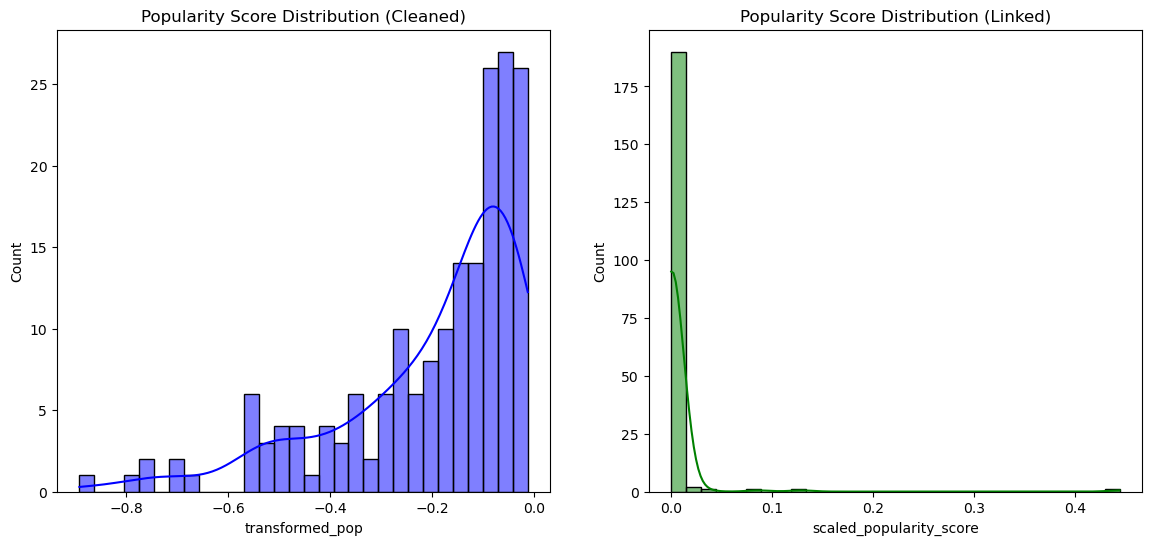

In [175]:
#histograms of popularity scores 

plt.figure(figsize=(14, 6))
submissions_cleaned_df['transformed_pop'] = np.log(submissions_cleaned_df['pop_score'])


plt.subplot(1, 2, 1)
sns.histplot(submissions_cleaned_df['transformed_pop'], bins=30, kde=True, color='blue')
plt.title('Popularity Score Distribution (Cleaned)')

plt.subplot(1, 2, 2)
sns.histplot(submissions_linked_df['scaled_popularity_score'].head(196), bins=30, kde=True, color='green')# take the same number as the other distrubition to be able to do a side-by-side comparison 
plt.title('Popularity Score Distribution (Linked)')
plt.show()

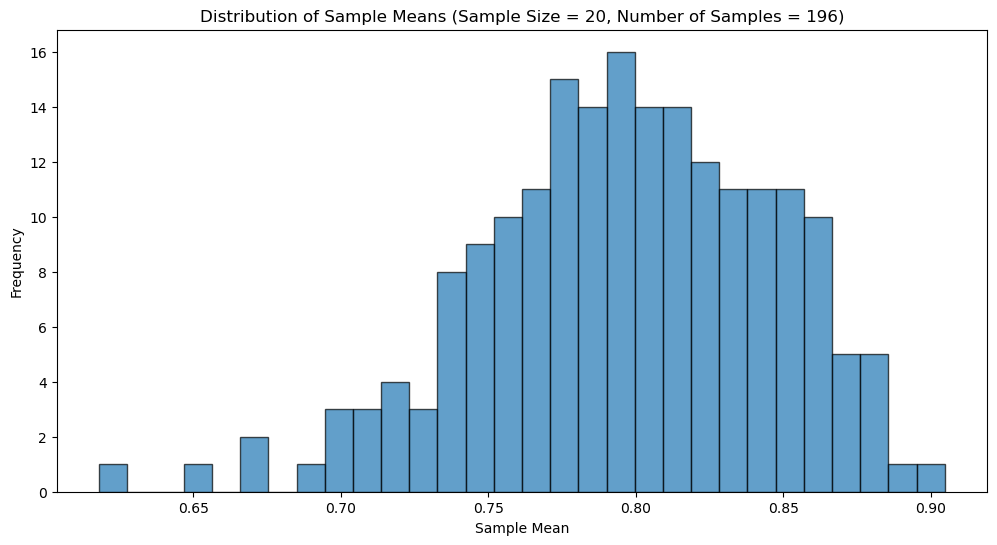

In [153]:
#apply CLT to hopefully get a more normal distribution of pop_scores

sample_size = 20 
num_samples = submissions_cleaned_df.shape[0]

def applyCLT(data, sample_size, num_samples):
    sample_means = []
    for _ in range(num_samples):  #iterate through the number of samples you want to take 
        sample = data.sample(n=sample_size, replace=True) #take a sample of size smaple_size 
        sample_means.append(sample.mean())   #add the mean of that sample top the sample_means list 
    return sample_means


sample_means = applyCLT(submissions_cleaned_df['pop_score'], sample_size, num_samples)
submissions_cleaned_df['pop_score_CLT'] = sample_means

plt.figure(figsize=(12, 6))
plt.hist(sample_means, bins=30, edgecolor='k', alpha=0.7)
plt.title(f'Distribution of Sample Means (Sample Size = {sample_size}, Number of Samples = {num_samples})')
plt.xlabel('Sample Mean')
plt.ylabel('Frequency')
plt.show()
#result: more normal looking !

In [155]:
submissions_linked_df[submissions_linked_df['num_comments'] > 0]

submissions_linked_df['comment_based_popularity_score'] = (submissions_linked_df['positive_count'] + submissions_linked_df['negative_count']) 



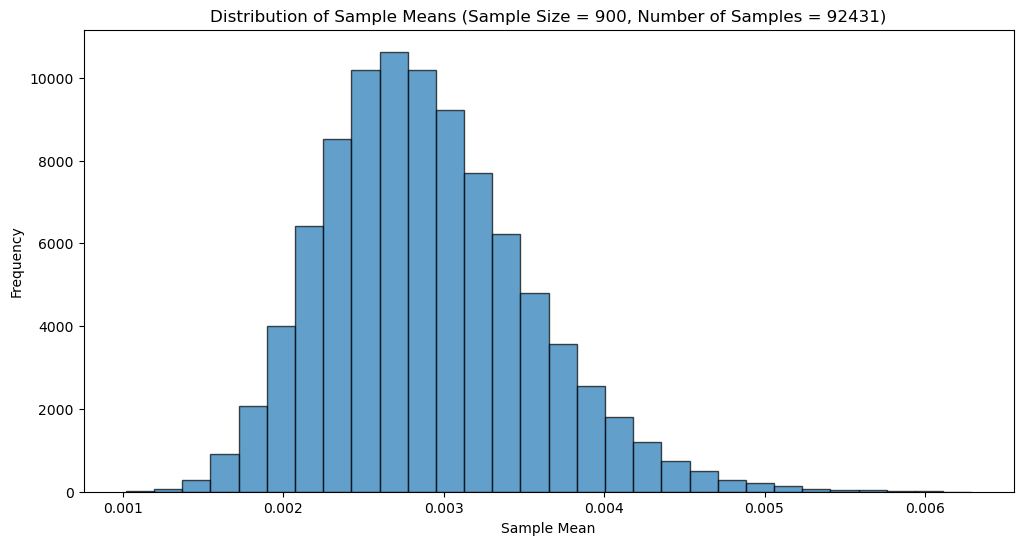

In [156]:
#apply CLT to the scaled popularity scores 
sample_size = 900
num_samples= submissions_linked_df.shape[0]
#some observations will be included in multiple samples, but this will give a more nice normal distribution 

sample_means = applyCLT(submissions_linked_df['scaled_popularity_score'], sample_size
                        ,num_samples)

submissions_linked_df['scaled_popularity_score_CLT'] = sample_means
plt.figure(figsize=(12, 6))
plt.hist(sample_means, bins=30, edgecolor='k', alpha=0.7)
plt.title(f'Distribution of Sample Means (Sample Size = {sample_size}, Number of Samples = {num_samples})')
plt.xlabel('Sample Mean')
plt.ylabel('Frequency')
plt.show()

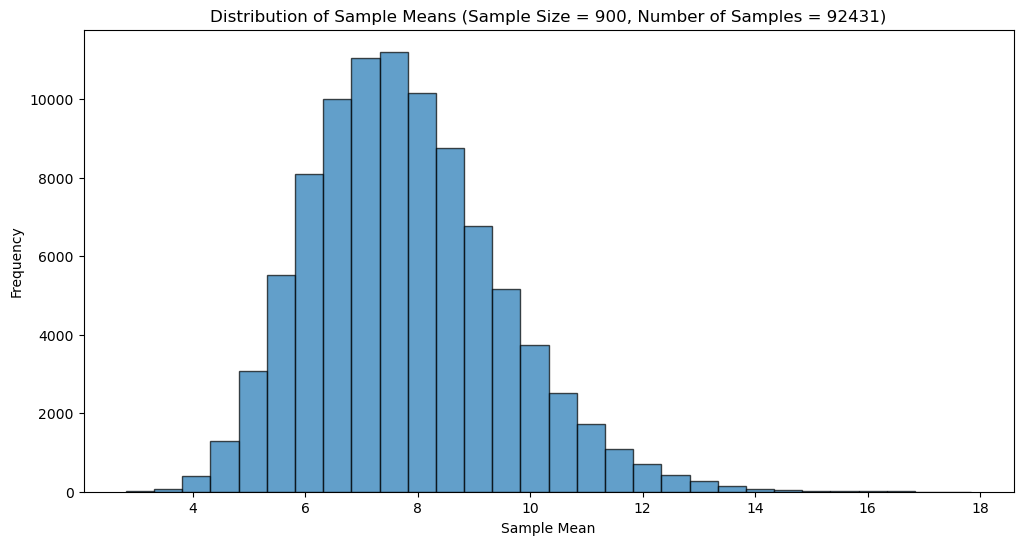

In [157]:
#apply CLT to the comment based populairty scores 
sample_size = 900
num_samples= submissions_linked_df.shape[0]
#some observations will be included in multiple samples, but this will give a more nice normal distribution 

sample_means = applyCLT(submissions_linked_df['comment_based_popularity_score'], sample_size
                        ,num_samples)
 
submissions_linked_df['comment_based_popularity_score_CLT'] = sample_means
plt.figure(figsize=(12, 6))
plt.hist(sample_means, bins=30, edgecolor='k', alpha=0.7)
plt.title(f'Distribution of Sample Means (Sample Size = {sample_size}, Number of Samples = {num_samples})')
plt.xlabel('Sample Mean')
plt.ylabel('Frequency')
plt.show()

In [158]:
#get the three groups
positive_popularity = submissions_linked_df[submissions_linked_df['sentiment_nltk']>=0.5]['scaled_popularity_score']
neutral_condition = (submissions_linked_df['sentiment_nltk'] > -0.5) & (submissions_linked_df['sentiment_nltk'] < 0.5)


neutral_popularity = submissions_linked_df.loc[neutral_condition, 'scaled_popularity_score']
negative_popularity = submissions_linked_df[submissions_linked_df['sentiment'] <=-0.5]['scaled_popularity_score']

#we can assume normally distributed data based on teh number of samples here 

print("Number of positive samples:", positive_popularity.count())
print("Number of neutral samples:", neutral_popularity.count())
print("Number of negative samples:", negative_popularity.count())

print("\n\n")

print("Result of ANOVA test: \n\n The p value is: ")

print(stats.f_oneway(positive_popularity, neutral_popularity, negative_popularity).pvalue)







Number of positive samples: 9591
Number of neutral samples: 76932
Number of negative samples: 11990



Result of ANOVA test: 

 The p value is: 
1.8867591859830593e-49


In [160]:
#since the p value is very small, we can do the tukey test to see which means are different 
tukey = pairwise_tukeyhsd(submissions_linked_df['scaled_popularity_score'], groups=submissions_linked_df['sentiment'], alpha=0.05)


print(tukey)

#conclusion: all means are different -> no significant results 

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
    -1      0  -0.0029   0.0 -0.0033 -0.0024   True
    -1      1  -0.0015   0.0  -0.002  -0.001   True
     0      1   0.0014   0.0  0.0011  0.0018   True
---------------------------------------------------


In [161]:
#perform a t-test to see if positive vs negative is significant 
t_statistic, p_value = stats.ttest_ind(positive_popularity, negative_popularity, equal_var=False)
print(p_value)

0.008680816524170173


In [162]:

#get the three groups
positive_popularity = submissions_linked_df[submissions_linked_df['sentiment_nltk']>=0.5]['comment_based_popularity_score']
neutral_submissions= (submissions_linked_df['sentiment_nltk'] > -0.5) & (submissions_linked_df['sentiment_nltk'] < 0.5)
neutral_popularity = submissions_linked_df.loc[neutral_submissions, 'comment_based_popularity_score']
negative_popularity = submissions_linked_df[submissions_linked_df['sentiment'] <=-0.5]['comment_based_popularity_score']

#we can assume normally distributed data based on teh number of samples here 

print("Number of positive samples:", positive_popularity.count())
print("Number of neutral samples:", neutral_popularity.count())
print("Number of negative samples:", negative_popularity.count())

print("\n\n")

print("Result of ANOVA test: \n\n The p value is: ")

print(stats.f_oneway(positive_popularity, neutral_popularity, negative_popularity).pvalue)
#slightly better but not that much better than the popularity score based on the upvotes-downvotes(they are essentially the same)




Number of positive samples: 9591
Number of neutral samples: 76932
Number of negative samples: 11990



Result of ANOVA test: 

 The p value is: 
3.7502503836024564e-57


In [163]:
tukey = pairwise_tukeyhsd(submissions_linked_df['comment_based_popularity_score'], groups=submissions_linked_df['sentiment'], alpha=0.05)

print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
    -1      0  -7.6074   0.0  -8.799 -6.4158   True
    -1      1  -3.7741   0.0 -5.1215 -2.4267   True
     0      1   3.8333   0.0  2.8952  4.7714   True
---------------------------------------------------


In [164]:

positive_popularity = submissions_cleaned_df[submissions_cleaned_df['sentiment_score'] >= 0.5]['pop_score']
neutral_submissions= (submissions_cleaned_df['sentiment_score'] > -0.5) & (submissions_cleaned_df['sentiment_score'] < 0.5)
neutral_popularity = submissions_cleaned_df.loc[neutral_submissions, 'pop_score']
negative_popularity = submissions_cleaned_df[submissions_df['sentiment_score'] <=-0.5 ]['pop_score']

#we can assume normally distributed data based on teh number of samples here 

print("Number of positive samples:", positive_popularity.count())
print("Number of neutral samples:", neutral_popularity.count())
print("Number of negative samples:", negative_popularity.count())

print("\n\n")

print("Result of ANOVA test: \n\n The p value is: ")

print(stats.f_oneway(positive_popularity, neutral_popularity, negative_popularity).pvalue)
#slightly better but not that much better than the popularity score based on the upvotes-downvotes(they are essentially the same)


Number of positive samples: 21
Number of neutral samples: 139
Number of negative samples: 36



Result of ANOVA test: 

 The p value is: 
0.9596398515792344


In [165]:
subreddit_groups = [submissions_linked_df[submissions_linked_df['subreddit'] == sub]['sentiment_nltk']
                     for sub in submissions_linked_df['subreddit'].unique()]
anova_result = stats.f_oneway(*subreddit_groups)
print("ANOVA Result:", anova_result)                            

ANOVA Result: F_onewayResult(statistic=182.7848120275627, pvalue=5.9448111385746e-80)


In [166]:
#how does the sentiment score of submissions vary across differnt comment counts? 
bins = [0, 10, 100, 300,500, 750, 1000, 1500, submissions_linked_df['num_comments'].max()] #max for this dataframe is ~1600
labels = ['0-10', '11-100', '101-300','301-500', '501-750', '751-1000','1001-1500', '1501+']
submissions_linked_df['comment_bin'] = pd.cut(submissions_linked_df['num_comments'], bins=bins, labels=labels)


#for each bin in the labels, filter the datframe to include the rows where comment_bin = bin label

comment_bins = [submissions_linked_df[submissions_linked_df['comment_bin'] == bin]['sentiment_nltk'] # then get the sentiment score 
                for bin in labels]
anova_result = stats.f_oneway(*comment_bins) 

print("ANOVA Result:", anova_result)



ANOVA Result: F_onewayResult(statistic=6.916646601665331, pvalue=2.9773966610739327e-08)


In [167]:
# is there a reslationship between the score of comments and the sentiment of comments? 

X = comments_df[['score']]
y = comments_df['sentiment_nltk']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         sentiment_nltk   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     15.65
Date:                Sun, 28 Jul 2024   Prob (F-statistic):           7.63e-05
Time:                        17:29:18   Log-Likelihood:            -8.6302e+05
No. Observations:             1534050   AIC:                         1.726e+06
Df Residuals:                 1534048   BIC:                         1.726e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1343      0.000    388.413      0.0

In [168]:
#there should be a strong associattion between the sentiment and body of the subnission 
contingency_table = pd.crosstab(submissions_linked_df['body_tokenized'], submissions_linked_df['sentiment'])
chi2_stat, p_value, dof, ex = stats.chi2_contingency(contingency_table)

print(f"Chi-Squared Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:\n", ex)


Chi-Squared Statistic: 184856.0
P-Value: 1.557304917221215e-20
Degrees of Freedom: 179282
Expected Frequencies:
 [[0.12972259 0.63078288 0.23949453]
 [0.12972259 0.63078288 0.23949453]
 [0.12972259 0.63078288 0.23949453]
 ...
 [0.12972259 0.63078288 0.23949453]
 [0.12972259 0.63078288 0.23949453]
 [0.12972259 0.63078288 0.23949453]]


In [169]:
#now redo the popularity score tests with the transformed data 

positive_popularity = submissions_cleaned_df[submissions_cleaned_df['sentiment_score'] >= 0.5]['pop_score_CLT']
neutral_submissions = (submissions_cleaned_df['sentiment_score'] > -0.5) & (submissions_cleaned_df['sentiment_score'] 
neutral_popularity = submissions_cleaned_df.loc[neutral_submissions, 'pop_score_CLT']
negative_popularity = submissions_cleaned_df[submissions_df['sentiment_score'] <=-0.5 ]['pop_score_CLT']

#we can assume normally distributed data based on teh number of samples here 

print("Number of positive samples:", positive_popularity.count())
print("Number of neutral samples:", neutral_popularity.count())
print("Number of negative samples:", negative_popularity.count())

print("\n\n")

print("Result of ANOVA test: \n\n The p value is: ")

print(stats.f_oneway(positive_popularity, neutral_popularity, negative_popularity).pvalue)
#slightly better but not that much better than the popularity score based on the upvotes-downvotes(they are essentially the same)


Number of positive samples: 21
Number of neutral samples: 139
Number of negative samples: 36



Result of ANOVA test: 

 The p value is: 
0.9718996593491253


In [172]:
#now redo the popularity score tests with the transformed data 

positive_popularity = submissions_linked_df[submissions_linked_df['sentiment_nltk'] >= 0.5]['scaled_popularity_score_CLT']
neutral_submissions = (submissions_linked_df['sentiment_nltk'] > -0.5) & (submissions_linked_df['sentiment_nltk'] < 0.5)
neutral_popularity = submissions_linked_df.loc[neutral_submissions, 'scaled_popularity_score_CLT']
negative_popularity = submissions_linked_df[submissions_linked_df['sentiment_nltk'] <=-0.5 ]['scaled_popularity_score_CLT']

#we can assume normally distributed data based on teh number of samples here 

print("Number of positive samples:", positive_popularity.count())
print("Number of neutral samples:", neutral_popularity.count())
print("Number of negative samples:", negative_popularity.count())

print("\n\n")

print("Result of ANOVA test: \n\n The p value is: ")

print(stats.f_oneway(positive_popularity, neutral_popularity, negative_popularity).pvalue)
#slightly better but not that much better than the popularity score based on the upvotes-downvotes(they are essentially the same)


Number of positive samples: 9591
Number of neutral samples: 76932
Number of negative samples: 5908



Result of ANOVA test: 

 The p value is: 
0.18682280000485638


In [173]:
#now redo the popularity score tests with the transformed data 

positive_popularity = submissions_linked_df[submissions_linked_df['sentiment_nltk'] >= 0.5]['comment_based_popularity_score_CLT']
neutral_submissions = (submissions_linked_df['sentiment_nltk'] > -0.5) & (submissions_linked_df['sentiment_nltk'] < 0.5)
neutral_popularity = submissions_linked_df.loc[neutral_submissions, 'comment_based_popularity_score_CLT']
negative_popularity = submissions_linked_df[submissions_linked_df['sentiment_nltk'] <=-0.5 ]['comment_based_popularity_score_CLT']

#we can assume normally distributed data based on teh number of samples here 

print("Number of positive samples:", positive_popularity.count())
print("Number of neutral samples:", neutral_popularity.count())
print("Number of negative samples:", negative_popularity.count())

print("\n\n")

print("Result of ANOVA test: \n\n The p value is: ")

print(stats.f_oneway(positive_popularity, neutral_popularity, negative_popularity).pvalue)
#slightly better but not that much better than the popularity score based on the upvotes-downvotes(they are essentially the same)


Number of positive samples: 9591
Number of neutral samples: 76932
Number of negative samples: 5908



Result of ANOVA test: 

 The p value is: 
0.495847803240795
